## Student Number: 233137668

## Name: Shane O'Sullivan

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv('insurance.csv')

In [2]:
# Data Summary
data.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
# Insurance Variable
insurance_median = data['insurance_cost'].median()
print(insurance_median)
data['insurance_cost_binary'] = (data['insurance_cost'] > insurance_median)

# Drop insurance_cost:
data=data.drop(columns=['insurance_cost'])
data.head()

9382.033


age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                  False
1   18    male  34.100         0     no  southeast                  False
2   18  female  26.315         0     no  northeast                  False
3   18  female  38.665         2     no  northeast                  False
4   18  female  35.625         0     no  northeast                  False

In [4]:
data.describe()

age          bmi     children
count  1338.000000  1338.000000  1338.000000
mean     39.207025    30.663397     1.094918
std      14.049960     6.098187     1.205493
min      18.000000    15.960000     0.000000
25%      27.000000    26.296250     0.000000
50%      39.000000    30.400000     1.000000
75%      51.000000    34.693750     2.000000
max      64.000000    53.130000     5.000000

In [5]:
data.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>, <Axes: >]], dtype=object)

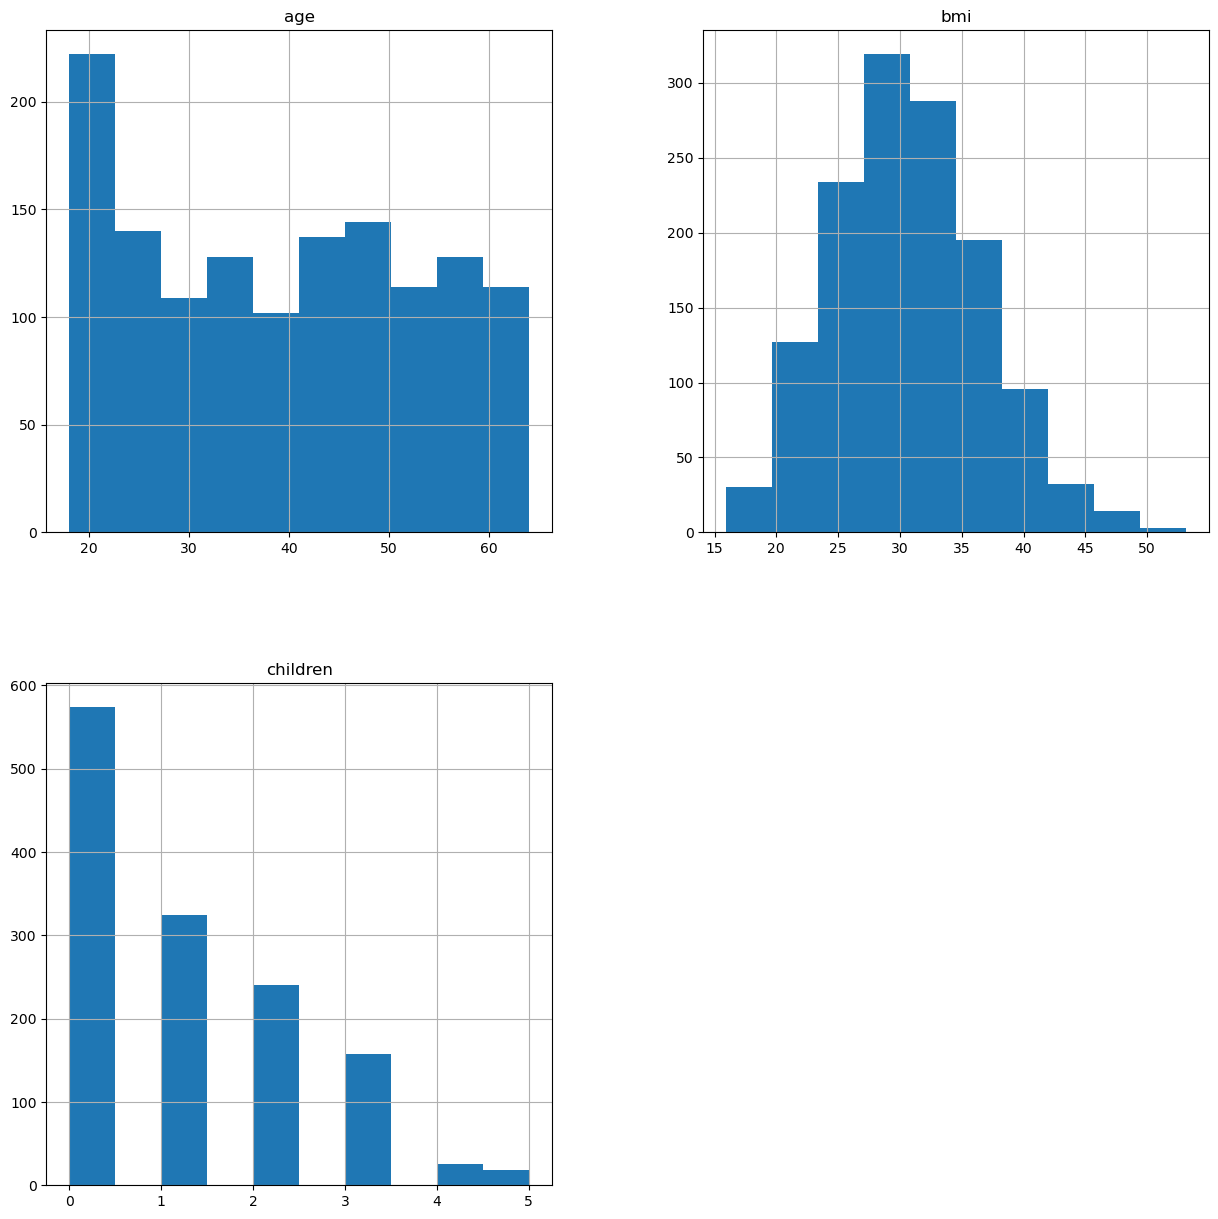

In [6]:
# Variable Histograms
# Age
data.hist(bins=10, figsize=(15,15))

In [7]:
# Remove target variable from dataset
y = data['insurance_cost_binary']
X = data.drop('insurance_cost_binary', axis=1)
y.value_counts()

False    669
True     669
Name: insurance_cost_binary, dtype: int64

In [8]:
# Variable Transformation & Encoding Pipeline
# Gender, Children, Smoker, Region and Insurance_cost_binary are all categorical variables
categorical_variables = ['gender','children','smoker','region']
transform_category = Pipeline(steps = [
    ('onehotencode',OneHotEncoder(handle_unknown='ignore'))
    ])
# BMI Variable Transform:
bmi_variable = ['bmi']
transform_bmi = Pipeline(steps = [
    ('standard_scaler', StandardScaler())
    ])

# Age Variable Transform
age_variable = ['age']
transform_age = Pipeline(steps = [
    ("log_transform", FunctionTransformer(np.log)),
    ('standard_scaler', StandardScaler())
    ])

In [9]:
# Preprocessing Pipeline
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("categorical", transform_category, categorical_variables),
        ("bmi", transform_bmi, bmi_variable),
        ("age", transform_age, age_variable),
    ],
    remainder='passthrough'
)

In [10]:
# Split Dataset into train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=13, stratify=y)

In [11]:
# Support Vector Machine Model:
pipe = Pipeline(steps = [
    ('preprocess',preprocess_pipeline),
    ('svm', svm.SVC(probability=True))
])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'children',
                                                   'smoker', 'region']),
                                                 ('bmi',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('age',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('svm', SVC(probability=True))])

In [12]:
# GridSearchCV Parameter Grid
parameter_grid = {
    'svm__C' : [0.01,0.1,1,10],
    'svm__gamma' : [0.001,0.01,0.1,1],
    'svm__kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}

# Prepare and fit model
grid_search = GridSearchCV(pipe, parameter_grid, n_jobs=-1, cv=5, refit=True)
grid_search.fit(X_train,y_train)

SVM_best_model = grid_search.best_estimator_
SVM_best_parameters = grid_search.best_params_

# Results
print("The best SVM Model score was: ", grid_search.best_score_)
print("The best SVM Model parameters were: ", grid_search.best_params_)

The best SVM Model score was:  0.9205607476635513
The best SVM Model parameters were:  {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [13]:
# Random Forest Model:
pipe = Pipeline(steps = [
    ('preprocess',preprocess_pipeline),
    ('rf', RandomForestClassifier())
])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'children',
                                                   'smoker', 'region']),
                                                 ('bmi',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('age',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('rf', RandomForestClassifier())])

In [14]:
# Random Forest Parameter Grid:
parameter_grid = {
    'rf__n_estimators' : [5,10,20,30,40,50],
    'rf__max_depth': [2, 4, 6, 8, 10],
    'rf__criterion': ['gini', 'entropy', 'log_loss']
}

# Prepare and fit model
random_forest_search = GridSearchCV(pipe, parameter_grid, n_jobs=-1, cv=5, refit=True)
random_forest_search.fit(X_train,y_train)

random_forest_best_model = random_forest_search.best_estimator_
random_forest_best_paramters = random_forest_search.best_params_

# Results
print("The best Random Forest Model score was: ", random_forest_search.best_score_)
print("The best Random Forest Model parameters were: ", random_forest_search.best_params_)

The best Random Forest Model score was:  0.9373831775700936
The best Random Forest Model parameters were:  {'rf__criterion': 'entropy', 'rf__max_depth': 8, 'rf__n_estimators': 50}


In [16]:
# K Nearest Neighbours Model:
pipe = Pipeline(steps = [
    ('preprocess',preprocess_pipeline),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'children',
                                                   'smoker', 'region']),
                                                 ('bmi',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('age',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('pca', PCA()), ('knn', KNeighborsClassifier())])

In [17]:
# K Nearest Neighbours Parameter Grid:
parameter_grid = {
    'knn__n_neighbors' : [3,5,7,9],
    'knn__weights': ['uniform','distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'pca__n_components' : [2,3,4,5,6]
}

# Prepare and fit model
knn_search = GridSearchCV(pipe, parameter_grid, n_jobs=-1, cv=5, refit=True)
knn_search.fit(X_train,y_train)

knn_best_model = knn_search.best_estimator_
knn_best_paramters = knn_search.best_params_

# Results
print("The best KNN Model score was: ", knn_search.best_score_)
print("The best KNN Model parameters were: ", knn_search.best_params_)

The best KNN Model score was:  0.9186915887850468
The best KNN Model parameters were:  {'knn__algorithm': 'auto', 'knn__n_neighbors': 9, 'knn__weights': 'distance', 'pca__n_components': 5}


In [18]:
def evaluate_model(X_test, y_test, model):
    ''' Evaluate performance of models'''
    _probabilities = model.predict_proba(X_test)[:, 1]
    _predicted_values = model.predict(X_test)
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [19]:
# Calculate Accuracy Rates
mean_fpr = np.linspace(start=0, stop=1, num=100)
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, random_forest_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, knn_best_model)

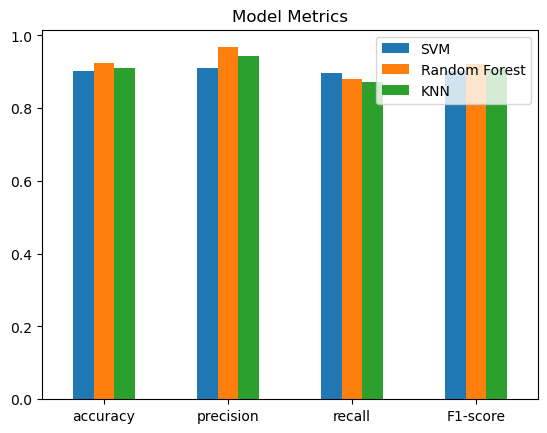

In [20]:
# Plot Model Metrics
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'KNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="upper right")
plt.title("Model Metrics")
plt.show()

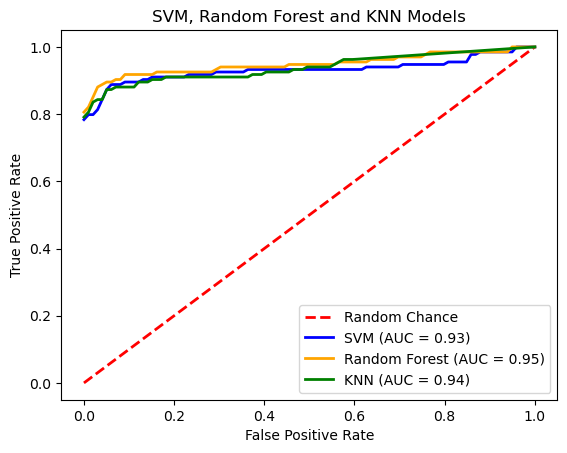

In [21]:
# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Chance')
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc))
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc))
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (KNN_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM, Random Forest and KNN Models')
plt.legend(loc="lower right")
plt.show()